In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Wczytujemy zbiór danych, który jest zbiorem punktów geograficznych. Jest ten zbiór dość duży (360 tysięcy wierszy), więc w ramach ćwiczenia obcinamy go do 20 tys. wierszy.
#### Zgodnie z dokumentacją niniejszego zbioru musimy podzielić pierwszą rzędną przez 1.7, aby odległości pomiędzy punktami wydarzeń odpowiadały rzeczywistości na tej planecie

In [5]:
X = pd.read_csv("urbanGB.txt", names = ["x","y"], header = None )
X = X.to_numpy()
X = X [np.random.randint(len(X),size = 20000)]
X[:,0] = X[:,0]/1.7

# 1. K-means

### Zacznijmy od najbardziej standartowej metody klasteryzacji: k-średnich. Będziemy badali różne metryki, aby wybrać najlepszą liczbę klastrów. Pierwszą jest tzw. metoda "łokcia"

In [4]:
from sklearn.cluster import KMeans

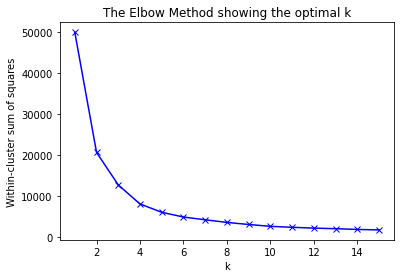

In [5]:
def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

wcss_vec = count_wcss_scores(X, 15)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Na pierwszy rzut oka "łokieć" jest przy 4 klastrach, ale nie jest to na pewno lepszym wyborem, bo po prawej stronie od niego nadal jest zauważalne zmniejszenie metryki. Ewentualnie dobrymy punktami mogą być 6,8,10. Badamy dalej:

In [6]:
# funkcja dla różnych metryk 
def count_clustering_scores(X, cluster_num, model, score_fun):
    
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores


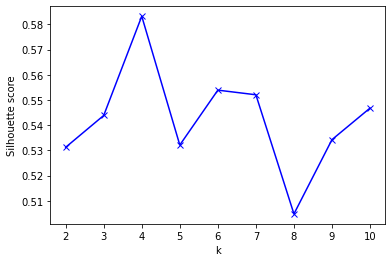

In [7]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### Dla metryki Silhoutte maksima są osiągane przy liczbie klastrów 4,6,7,10

## Wybierzmy teraz inną metrykę: średnią odległość między punktami klastra. 



In [9]:
def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

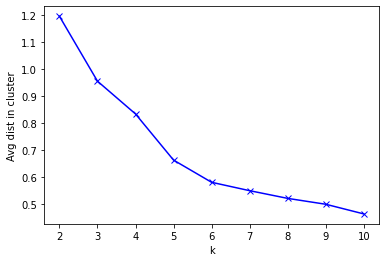

In [10]:
from scipy.spatial import distance
cluster_num_seq = range(2, 11)
scores_vec = count_clustering_scores(X, cluster_num_seq, KMeans, mean_inclust_dist)
plt.plot(cluster_num_seq, scores_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Avg dist in cluster')
plt.show()

###  Dążymy do małych odległości pomiędzy punktami wewnątrz klastrów. Zatem dobrymi punktami są liczby klastrów od 6 do 10.

### Na podstawie wybranych metryk najlepszymi liczbami klastrów, naszym zdaniem, są 4 i 6.

In [13]:
# funkcja dla wizualizacji metody k-średnich
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()


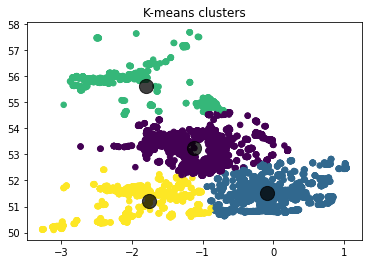

In [14]:
plot_kmeans_clusters(X, n_clusters=4)

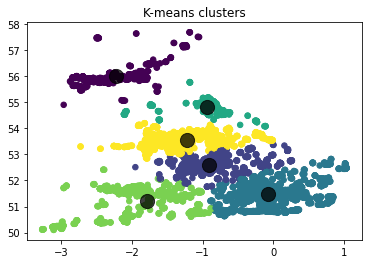

In [15]:
plot_kmeans_clusters(X, n_clusters=6)

# 2. K-metoids 

### Drugą wybraną przez nas metodą jest PAM algorytm. W tym przypadku zbadajmy metrykę Silhouette, średnią odległość między punktem w klastrze a środkiem oraz odległości pomiędzy klastrami

In [7]:
from sklearn_extra.cluster import KMedoids

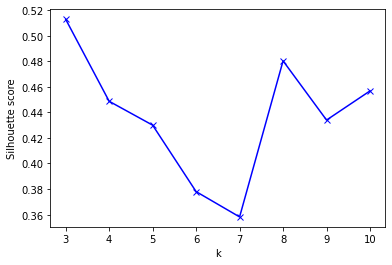

In [17]:
from sklearn.metrics import silhouette_score

cluster_num_seq = range(3, 11) 
scores_vec = count_clustering_scores(X, cluster_num_seq, KMedoids, silhouette_score)
plt.plot(cluster_num_seq, scores_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

### Maksima są osiągane przy liczbie klastrów 3,8, 10

In [19]:
def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

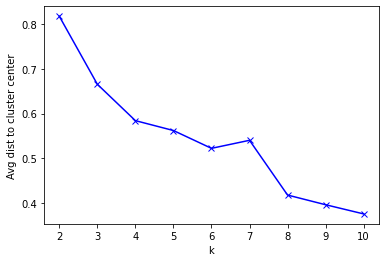

In [20]:
from scipy.spatial import distance
cluster_num_seq = range(2, 11)
scores_vec = count_clustering_scores(X, cluster_num_seq, KMedoids, mean_dist_to_center)
plt.plot(cluster_num_seq, scores_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Avg dist to cluster center')
plt.show()

In [1]:
def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

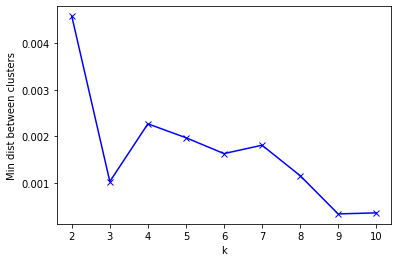

In [22]:
cluster_num_seq = range(2, 11)
scores_vec = count_clustering_scores(X, cluster_num_seq, KMedoids, min_interclust_dist)
plt.plot(cluster_num_seq, scores_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Min dist between clusters')
plt.show()

### Na podstawie wyników powyższych metryk uważamy, że najlepsza liczba klastrów dla tej metody jest 8.

In [2]:
def plot_kmedoids_clusters(X, n_clusters):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(X)
    y_kmedoids = kmedoids.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedoids, s=30, cmap='viridis')

    centers = kmedoids.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-medoids clusters')
    plt.show()

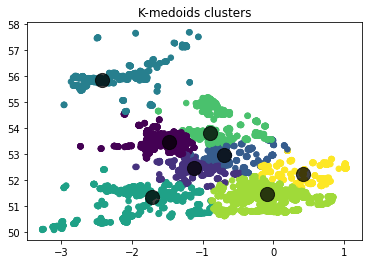

In [8]:
plot_kmedoids_clusters(X, n_clusters=8)

# Podsumowanie
* Dla k-średnich najlepsza liczba klastrów 4 lub 6
* Dla PAM-algorytmu - 8